###### Load Packages

In [71]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

###### Load Data

In [4]:
%%time
train_df = pd.read_csv( "train.csv" )
test_df = pd.read_csv( "test.csv" )

Wall time: 19 s


In [5]:
# To verify the data types and data format
train_df.info()
train_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


(200000, 202)

In [6]:
test_df.info()
test_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB


(200000, 201)

In [7]:
train_df.head( 10 )

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
5,train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
6,train_6,0,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,...,8.7830,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097
7,train_7,0,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,...,13.1700,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806
8,train_8,0,16.1071,2.4426,13.9307,5.6327,8.8014,6.1630,4.4514,10.1854,...,1.4298,14.7510,1.6395,1.4181,14.8370,-1.9940,-1.0733,8.1975,19.5114,4.8453
9,train_9,0,12.5088,1.9743,8.8960,5.4508,13.6043,-16.2859,6.0637,16.8410,...,0.5543,6.3160,1.0371,3.6885,14.8344,0.4467,14.1287,7.9133,16.2375,14.2514


In [15]:
train_df_0 = train_df[train_df['target'] == 0]
train_df_1 = train_df[train_df['target'] == 1]

In [16]:
train_df_0.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [17]:
train_df_1.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
13,train_13,1,16.3699,1.5934,16.7395,7.3330,12.1450,5.9004,4.8222,20.9729,...,7.4002,7.4031,4.3989,4.0978,17.3638,-1.3022,9.6846,9.0419,15.6064,-10.8529
29,train_29,1,5.3301,-2.6064,13.1913,3.1193,6.6483,-6.5659,5.9064,15.2341,...,5.9215,7.9676,2.3405,1.1482,23.2168,-2.0105,3.7600,9.4513,17.4105,-14.6897
63,train_63,1,7.7072,0.0183,9.9974,8.3524,9.2886,-13.3627,6.0425,10.1108,...,1.5832,5.0039,3.8814,7.4241,21.4844,-0.8297,-3.0468,7.5790,15.7685,5.4769
65,train_65,1,10.5358,-2.5439,8.7394,6.7548,14.4099,-3.8724,5.1584,15.8381,...,4.6648,6.4227,3.4025,-4.0882,14.1174,-0.2472,5.3847,8.6949,15.1340,3.8449
71,train_71,1,6.7547,2.5973,14.2141,8.3514,7.4942,-1.3055,4.2336,15.0243,...,1.4677,3.5935,2.0013,1.5777,18.2820,-4.3408,6.8869,9.3567,18.9013,13.3447


In [18]:
train_df_0.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,179902.0,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,...,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000
mean,0.0,10.626681,-1.695770,10.665876,6.788979,11.072412,-5.146736,5.389620,16.549306,0.262347,...,3.149130,7.390800,1.949017,3.355403,18.017716,-0.155601,2.260297,8.919032,15.924058,-3.415273
std,0.0,3.008564,4.024813,2.612961,2.040082,1.620103,7.827522,0.857983,3.417700,3.331105,...,4.522568,2.997847,1.476456,3.982819,3.127715,1.422275,5.441118,0.917467,2.978539,10.434525
min,0.0,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-10.845500,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.0,8.429500,-4.790775,8.698025,5.247625,9.880600,-11.260950,4.756425,13.950125,-2.342575,...,-0.111850,5.130825,0.915300,0.612400,15.656700,-1.178700,-1.987375,8.262100,13.896000,-11.312025
50%,0.0,10.478600,-1.682600,10.529000,6.817000,11.104400,-4.917700,5.364400,16.460850,0.371400,...,3.117250,7.297000,1.928950,3.417550,17.982400,-0.184200,2.359700,8.897700,15.988500,-2.914000
75%,0.0,12.693075,1.287700,12.463900,8.317875,12.253100,0.844600,5.981300,19.108800,2.919300,...,6.296375,9.461300,2.969800,6.217075,20.417500,0.813000,6.513425,9.601500,18.095400,4.741400
max,0.0,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [57]:
train_df_1[['var_21','var_6','var_148','var_76','var_166','var_174','var_34','var_80','var_110','var_26','var_22']].describe()

,var_21,var_6,var_148,var_76,var_166,var_174,var_34,var_80,var_110,var_26,var_22
count,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000
mean,15.823715,5.581966,3.957942,4.580307,2.899436,18.893971,11.348866,4.513254,6.248459,-2.949112,4.821429
std,8.578688,0.922442,0.212396,8.483437,0.394379,7.623027,0.560916,8.041483,4.151065,6.446004,3.067136
min,-8.005400,2.496000,3.324400,-21.633300,1.977200,-2.037100,9.907600,-16.704500,-8.110000,-23.281000,-5.322500
25%,9.763125,4.882250,3.805925,-1.148025,2.626025,13.609325,10.941525,-0.867100,3.213550,-7.720300,2.534575
50%,15.592050,5.601800,3.960100,4.645650,2.897700,18.937400,11.350450,4.561700,6.126000,-3.117950,4.809300
75%,22.030475,6.218550,4.112000,10.832675,3.190900,24.608000,11.758275,10.699150,9.210550,1.359500,6.906200
max,43.952100,8.285200,4.752800,31.891900,4.220400,39.979000,13.134600,28.285700,19.519300,14.746600,14.594500


In [58]:
train_df_0[['var_21','var_6','var_148','var_76','var_166','var_174','var_34','var_80','var_110','var_26','var_22']].describe()

,var_21,var_6,var_148,var_76,var_166,var_174,var_34,var_80,var_110,var_26,var_22
count,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000
mean,17.418103,5.389620,3.994388,6.215158,2.970474,20.357774,11.443788,5.938240,5.431102,-4.178694,4.247785
std,8.137105,0.857983,0.197325,7.858068,0.366132,7.064789,0.538577,7.352254,3.776002,5.847831,2.816560
min,-10.089000,2.347300,3.320500,-20.924400,1.851200,-2.995300,9.816900,-18.042200,-9.239800,-24.243100,-5.164000
25%,11.742475,4.756425,3.858800,0.800250,2.706500,15.232800,11.042900,0.864150,2.776825,-8.385275,2.147800
50%,17.408200,5.364400,3.999400,6.472000,2.966900,20.346550,11.444450,6.209800,5.324400,-4.298600,4.216600
75%,23.195000,5.981300,4.133700,11.909200,3.246300,25.737225,11.852700,11.517675,7.982300,-0.239100,6.224800
max,49.044300,8.447700,4.731900,34.435200,4.214600,43.546800,13.287800,30.476900,19.312900,15.675100,14.594500


In [14]:
test_df.head(10)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846
5,test_5,5.9862,-2.2913,8.6058,7.0685,14.2465,-8.6761,4.2467,14.7632,1.8790,...,-2.1115,7.1178,-0.4249,8.8781,14.9438,-2.2151,-6.0233,9.8117,17.1127,10.8240
6,test_6,8.4624,-6.1065,7.3603,8.2627,12.0104,-7.2073,4.1670,13.0809,-4.3004,...,12.3609,6.8661,4.0971,8.8484,17.5010,0.0295,7.7443,9.1509,18.4736,5.1499
7,test_7,17.3035,-2.4212,13.3989,8.3998,11.0777,9.6449,5.9596,17.8477,-4.8068,...,4.4676,4.4214,0.9303,1.4994,15.2648,-1.7931,6.5316,10.4855,23.4631,0.7283
8,test_8,6.9856,0.8402,13.7161,4.7749,8.6784,-13.7607,4.3386,14.5843,2.5883,...,-3.4657,7.8754,2.4698,-0.0362,16.7144,0.1221,-1.4328,9.9207,16.9865,-3.3304
9,test_9,10.3811,-6.9348,14.6690,9.0941,11.9058,-10.8018,3.4508,20.2816,-1.4112,...,1.8052,11.0723,0.8907,4.7680,15.1425,0.6075,-4.4447,9.5788,15.8146,9.3457


In [21]:
TrainMissingCount = train_df.isnull().sum()
#print( TrainMissingCount )

In [20]:
TestMissingCount = test_df.isnull().sum()
#print( TestMissingCount )

In [50]:
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [51]:
test_df.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


Looks like, the target variable is train_df['target'] and the feature variables are from var_0 to var_199( 200 variables ). 
200000 entries are there in both train and test data set. Variables data types are same - float64.
There is no categorical variable in the dataset. So no encoding is required.
And no missing data in the training  and test data set. The variable count is same in both train and test data set.

As per the describe() function, the data looks good. no scaling is required. There is a difference between mean and standard deviation. But we can see the same variation between train and test data set.

In [22]:
X_train = train_df[list(train_df.columns[2:])]

In [53]:
X_train.head(10)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
5,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,3.5855,5.9790,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
6,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,-4.3781,7.9232,...,8.7830,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097
7,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,5.0647,7.1971,...,13.1700,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806
8,16.1071,2.4426,13.9307,5.6327,8.8014,6.1630,4.4514,10.1854,-3.1882,9.0827,...,1.4298,14.7510,1.6395,1.4181,14.8370,-1.9940,-1.0733,8.1975,19.5114,4.8453
9,12.5088,1.9743,8.8960,5.4508,13.6043,-16.2859,6.0637,16.8410,0.1287,7.9682,...,0.5543,6.3160,1.0371,3.6885,14.8344,0.4467,14.1287,7.9133,16.2375,14.2514


In [23]:
y_train = train_df['target']

In [55]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [24]:
X_test = test_df[list(test_df.columns[1:])]
X_test.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [68]:
learningRate = 0.1
xgbModel = xgb.XGBClassifier(   max_depth = 5,
                                objective = 'binary:logistic',
                                booster= 'gbtree',
                                learning_rate = learningRate,
                                base_score= 0.2,
                                alpha= 0.4,
                                n_estimators= 100,
                                seed= 1301,
                                silent= 1,
                                eta= 0.3,
                                gamma= 0,
                                min_child_weight= 1,
                                max_delta_step= 0,
                                subsample= .8,
                                colsample_bytree= .8,
                                reg_alpha=0,
                                reg_lambda= 1,
                                missing= None,
                                verbosity= 1,
                                nthread = 2 )


In [69]:
# xgb_param = xgbModel.get_xgb_params()
# xgtrain = xgb.DMatrix( X_train, label=train_df['target'])
# #do cross validation
# print ('Start cross validation')
# cvresult = xgb.cv( xgb_param, xgtrain, num_boost_round=100, nfold=5, metrics=['auc'], early_stopping_rounds=10, stratified=True, seed=1301)
# print('Best number of trees = {}'.format(cvresult.shape[0]))
# xgbModel.set_params(n_estimators=cvresult.shape[0])

In [72]:
idx         = 1
kf          = StratifiedKFold( n_splits = 5, random_state = 44000, shuffle = False )
features    = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target      = train_df['target']
oof         = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for train_index, val_index in kf.split( y_train, y_train ):
    print('\n{} of kfold {}'.format( idx, kf.n_splits ))
    trn_dat, trn_tgt = X_train.loc[ train_index ], y_train.loc[ train_index ]
    val_dat, val_tgt = X_train.loc[ val_index ], y_train.loc[ val_index ]
    xgbModel.fit( trn_dat, trn_tgt,
                  early_stopping_rounds = 20,
                  eval_set = [(trn_dat, trn_tgt), (val_dat, val_tgt)],
                  eval_metric = "auc", verbose = True )
    pred = xgbModel.predict( val_dat )
    print('accuracy_score', accuracy_score( val_tgt, pred ))
    idx += 1  
    oof[val_index] = xgbModel.predict(train_df.iloc[val_index][features])
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = xgbModel.feature_importances_
    fold_importance_df["fold"] = idx
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += xgbModel.predict(test_df[features]) / kf.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))


1 of kfold 5
[0]	validation_0-auc:0.638196	validation_1-auc:0.629913
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.666315	validation_1-auc:0.655314
[2]	validation_0-auc:0.687478	validation_1-auc:0.671928
[3]	validation_0-auc:0.69667	validation_1-auc:0.678449
[4]	validation_0-auc:0.710724	validation_1-auc:0.690044
[5]	validation_0-auc:0.717212	validation_1-auc:0.69439
[6]	validation_0-auc:0.722694	validation_1-auc:0.699126
[7]	validation_0-auc:0.731491	validation_1-auc:0.705039
[8]	validation_0-auc:0.743336	validation_1-auc:0.715957
[9]	validation_0-auc:0.747166	validation_1-auc:0.717689
[10]	validation_0-auc:0.75468	validation_1-auc:0.72549
[11]	validation_0-auc:0.76162	validation_1-auc:0.730277
[12]	validation_0-auc:0.769043	validation_1-auc:0.73621
[13]	validation_0-auc:0.775348	validation_1-auc:0.741672
[14]	validation_0-auc:0.778264	validation_1-auc

[39]	validation_0-auc:0.857756	validation_1-auc:0.805797
[40]	validation_0-auc:0.858677	validation_1-auc:0.806976
[41]	validation_0-auc:0.860763	validation_1-auc:0.809236
[42]	validation_0-auc:0.86232	validation_1-auc:0.810502
[43]	validation_0-auc:0.863036	validation_1-auc:0.81093
[44]	validation_0-auc:0.864014	validation_1-auc:0.811988
[45]	validation_0-auc:0.866124	validation_1-auc:0.813772
[46]	validation_0-auc:0.867538	validation_1-auc:0.815126
[47]	validation_0-auc:0.869412	validation_1-auc:0.816573
[48]	validation_0-auc:0.870707	validation_1-auc:0.817323
[49]	validation_0-auc:0.87129	validation_1-auc:0.817818
[50]	validation_0-auc:0.872718	validation_1-auc:0.818284
[51]	validation_0-auc:0.873795	validation_1-auc:0.818704
[52]	validation_0-auc:0.875388	validation_1-auc:0.820008
[53]	validation_0-auc:0.876689	validation_1-auc:0.821528
[54]	validation_0-auc:0.877895	validation_1-auc:0.822464
[55]	validation_0-auc:0.8791	validation_1-auc:0.823718
[56]	validation_0-auc:0.880106	valid

[80]	validation_0-auc:0.90186	validation_1-auc:0.843805
[81]	validation_0-auc:0.902906	validation_1-auc:0.844332
[82]	validation_0-auc:0.903612	validation_1-auc:0.845261
[83]	validation_0-auc:0.904145	validation_1-auc:0.845663
[84]	validation_0-auc:0.904379	validation_1-auc:0.84574
[85]	validation_0-auc:0.904999	validation_1-auc:0.84609
[86]	validation_0-auc:0.905499	validation_1-auc:0.846492
[87]	validation_0-auc:0.906144	validation_1-auc:0.846974
[88]	validation_0-auc:0.906869	validation_1-auc:0.847424
[89]	validation_0-auc:0.907299	validation_1-auc:0.847674
[90]	validation_0-auc:0.907682	validation_1-auc:0.84793
[91]	validation_0-auc:0.908514	validation_1-auc:0.848505
[92]	validation_0-auc:0.909051	validation_1-auc:0.848982
[93]	validation_0-auc:0.909763	validation_1-auc:0.84956
[94]	validation_0-auc:0.910437	validation_1-auc:0.849881
[95]	validation_0-auc:0.911082	validation_1-auc:0.850428
[96]	validation_0-auc:0.911539	validation_1-auc:0.850803
[97]	validation_0-auc:0.912183	valid

[18]	validation_0-auc:0.800433	validation_1-auc:0.773142
[19]	validation_0-auc:0.804975	validation_1-auc:0.777424
[20]	validation_0-auc:0.808038	validation_1-auc:0.78001
[21]	validation_0-auc:0.809529	validation_1-auc:0.781967
[22]	validation_0-auc:0.814346	validation_1-auc:0.78657
[23]	validation_0-auc:0.816977	validation_1-auc:0.788574
[24]	validation_0-auc:0.820262	validation_1-auc:0.791577
[25]	validation_0-auc:0.823741	validation_1-auc:0.793971
[26]	validation_0-auc:0.825556	validation_1-auc:0.7951
[27]	validation_0-auc:0.827351	validation_1-auc:0.796593
[28]	validation_0-auc:0.828632	validation_1-auc:0.797616
[29]	validation_0-auc:0.83179	validation_1-auc:0.800001
[30]	validation_0-auc:0.834192	validation_1-auc:0.802231
[31]	validation_0-auc:0.836997	validation_1-auc:0.804783
[32]	validation_0-auc:0.839302	validation_1-auc:0.806698
[33]	validation_0-auc:0.841355	validation_1-auc:0.807764
[34]	validation_0-auc:0.842736	validation_1-auc:0.8092
[35]	validation_0-auc:0.846072	validat

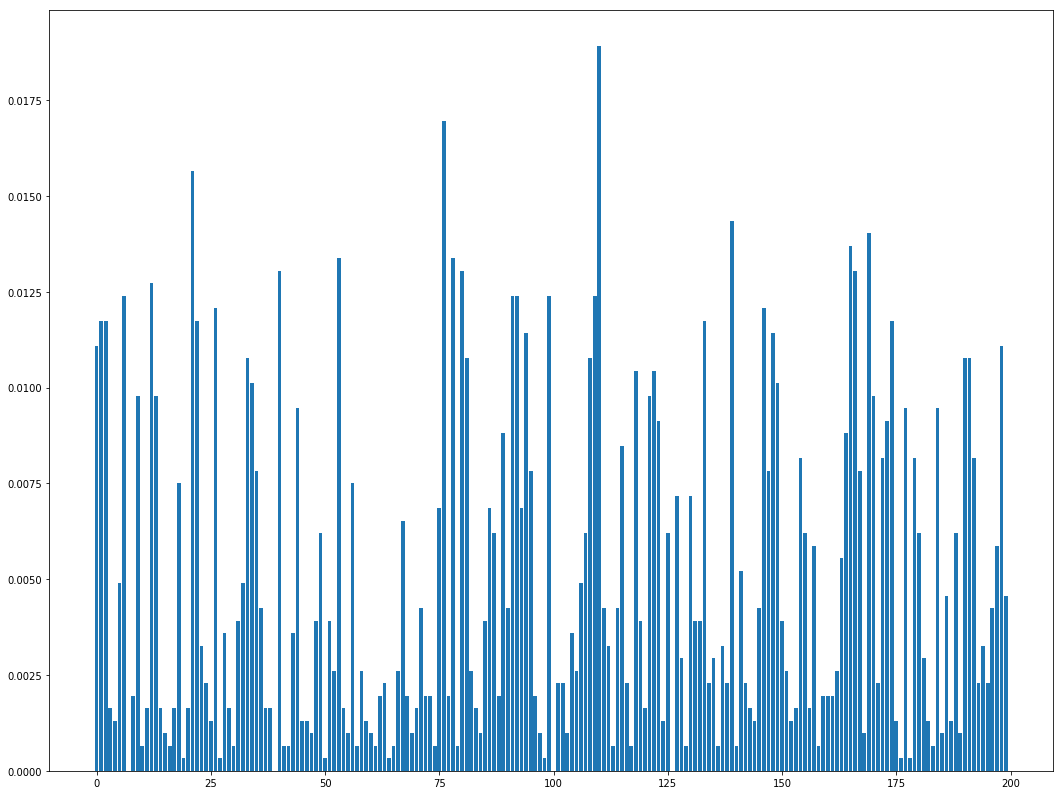

In [73]:
plt.figure( figsize=( 18, 14 ))
plt.bar(range(len(xgbModel.feature_importances_)), xgbModel.feature_importances_)
plt.show()

In [98]:
pred_prob_val = pd.DataFrame()
pred_prob_val['target'] = xgbModel.predict_proba( data=X_test )[:,1]
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = xgbModel.predict( X_test )
sub_df.loc[pred_prob_val['target'] > 0.36, 'target'] = 1
sub_df.to_csv("submission_.csv", index=False)

3392


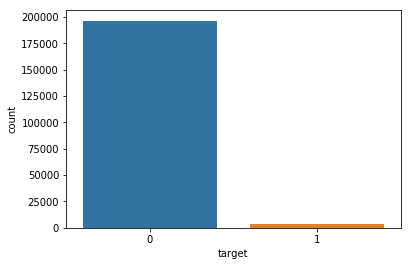

In [99]:
# Visualizing the train - target variable
import seaborn as sns
sns.countplot( sub_df['target'] )
print(sum(sub_df['target']))


In [95]:
sub_df['target'] = xgbModel.predict( X_test )
print(sum(sub_df['target']))

1094
